This notebook explores basemap's quiver plots in different map projections.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy.interpolate as interp

%matplotlib inline

# Load GIOPS forecast data
Also, create an entirely 'zonal' velocity field.

In [2]:
time_index, depth_index = 0,0 

variable='vomecrty'
fname = '/data/hdd/giops/forecast/CMC_giops_{}_depth_all_latlon0.2x0.2_24h-mean_2017110700_P024.nc'.format(variable)
f = nc.Dataset(fname)
lonV = f.variables['longitude']
latV = f.variables['latitude']
V_GIOPS = f.variables[variable][time_index,depth_index,:,:]

variable='vozocrtx'
fname = '/data/hdd/giops/forecast/CMC_giops_{}_depth_all_latlon0.2x0.2_24h-mean_2017110700_P024.nc'.format(variable)
f = nc.Dataset(fname)
lonU = f.variables['longitude']
latU = f.variables['latitude']
U_GIOPS = f.variables[variable][time_index,depth_index,:,:]

Check that coordintaes in U/V files are equal.

In [3]:
print(np.array_equal(lonU[:],lonU[:]))
print(np.array_equal(latU[:],latU[:]))

True
True


In [4]:
lon=lonU[:]
lat=latU[:]

In [5]:
print(lonU)
print((np.diff(lon)>0).all())
print((np.diff(lat)>0).all())

<type 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    valid_min: 0.0
    valid_max: 360.0
    long_name: Longitude
    standard_name: longitude
    axis: X
unlimited dimensions: 
current shape = (1800,)
filling on, default _FillValue of 9.96920996839e+36 used

True
True


Basemap likes longitude increasing from -180 to 180 so adjust longitude and arrays now.

In [6]:
lon_adjust = (lon + 180. ) % (360.) - 180.
inds = np.argsort(lon_adjust)
lon_adjust=lon_adjust[inds]
U_GIOPS_adjust=U_GIOPS[:,inds]
mask = U_GIOPS.mask[:,inds]
U_GIOPS_adjust = np.ma.masked_array(U_GIOPS_adjust,mask=mask)
V_GIOPS_adjust=V_GIOPS[:,inds]
mask = V_GIOPS.mask[:,inds]
V_GIOPS_adjust = np.ma.masked_array(V_GIOPS_adjust,mask=mask)

Text(0.5,1,u'-180 to 180 grid')

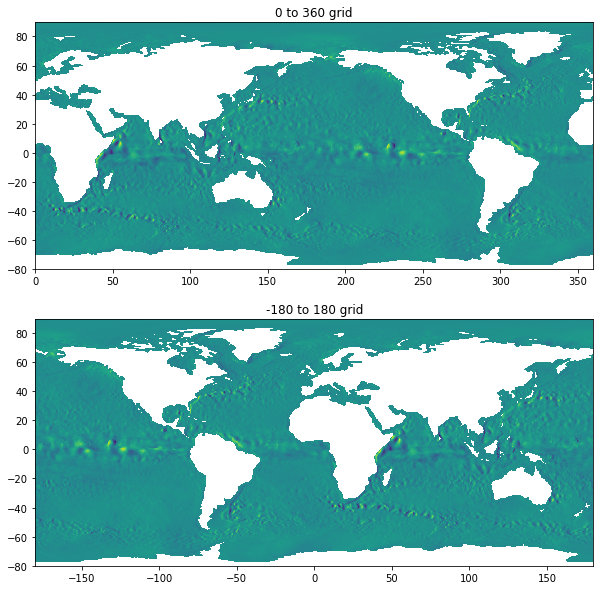

In [7]:
fig,axs=plt.subplots(2,1,figsize=(10,10))
ax=axs[0]
ax.pcolormesh(lon, lat, V_GIOPS)
ax.set_title('0 to 360 grid')
ax=axs[1]
ax.pcolormesh(lon_adjust, lat, V_GIOPS_adjust)
ax.set_title('-180 to 180 grid')


Create an eastward velocity field on the same grid.

In [8]:
U_east = np.ones_like(U_GIOPS_adjust)
U_east = np.ma.masked_array(U_east, mask=U_GIOPS_adjust.mask)

V_east = np.zeros_like(U_GIOPS_adjust)
V_east = np.ma.masked_array(V_east, mask=U_GIOPS_adjust.mask)

# Plotting with basemap
* Test plotting with different projections on basemap
* Use rotate_vector and latlon=True

## Documentation 
https://matplotlib.org/basemap/api/basemap_api.html
### rotate_vector
 rotate_vector(uin, vin, lons, lats, returnxy=False)

Rotate a vector field (uin,vin) on a rectilinear grid with longitudes = lons and latitudes = lats from geographical (lat/lon) into map projection (x/y) coordinates.

Differs from transform_vector in that no interpolation is done. The vector is returned on the same grid, but rotated into x,y coordinates.

The input vector field is defined in spherical coordinates (it has eastward and northward components) while the output vector field is rotated to map projection coordinates (relative to x and y). The magnitude of the vector is preserved.

Arguments 	Description

uin, vin 	input vector field on a lat/lon grid.

lons, lats 	**Arrays containing longitudes and latitudes (in degrees) of input data in increasing order. For non-cylindrical projections (those other than cyl, merc, cyl, gall and mill) lons must fit within range -180 to 180.**

Returns uout, vout (rotated vector field). If the optional keyword argument returnxy is True (default is False), returns uout,vout,x,y (where x,y are the map projection coordinates of the grid defined by lons,lats).

### latlon=True


quiver(x, y, u, v, *args, **kwargs)

Make a vector plot (u, v) with arrows on the map.

Arguments may be 1-D or 2-D arrays or sequences (see matplotlib.pyplot.quiver documentation for details).

**If latlon keyword is set to True, x,y are intrepreted as longitude and latitude in degrees. Data and longitudes are automatically shifted to match map projection region for cylindrical and pseudocylindrical projections, and x,y are transformed to map projection coordinates. If latlon is False (default), x and y are assumed to be map projection coordinates.**

Extra keyword ax can be used to override the default axis instance.

Other *args and **kwargs passed on to matplotlib.pyplot.quiver.


In [9]:
def compare_methods_cyl(U,V,lons,lats,st=75,scale=25):
    fig,axs = plt.subplots(1,2,figsize=(20,10))
    lonmesh,latmesh = np.meshgrid(lons, lats)
    
    for ax, method in zip(axs, ['rotate', 'latlon']):
        bmap = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,
                       llcrnrlon=-180,urcrnrlon=180,ax=ax)
        bmap.drawcoastlines()
        bmap.fillcontinents(color='coral',lake_color='aqua')
        bmap.drawparallels(np.arange(-90.,120.,30.))
        bmap.drawmeridians(np.arange(0.,360.,60.))
        if method == 'rotate':
            unew, vnew, x, y = bmap.rotate_vector(U, V, lonmesh, latmesh, returnxy=True)
            bmap.quiver(x[::st,::st],y[::st,::st],unew[::st,::st],vnew[::st,::st],
                        scale=scale,ax=ax)
            ax.set_title('Quiver plot with rotate vector')
        else:
            bmap.quiver(lonmesh[::st,::st],latmesh[::st,::st],U[::st,::st],V[::st,::st],
                        latlon=True,scale=scale,ax=ax)
            ax.set_title('Quiver plot with latlon=True')
    return fig

### A cylindrical projection, eastward velocity

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


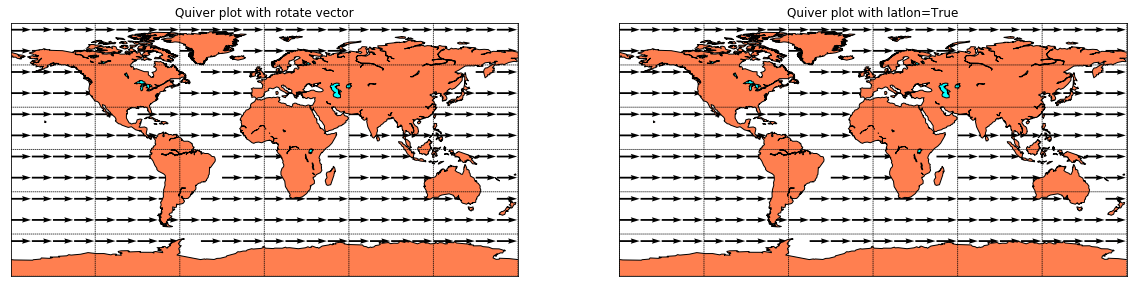

In [10]:
fig = compare_methods_cyl(U_east,V_east,lon_adjust,lat)

### A cylindrical projection, GIOPS

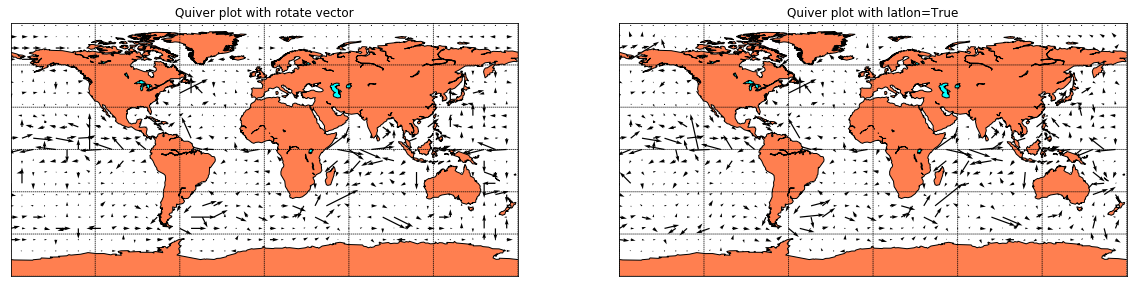

In [11]:
fig = compare_methods_cyl(U_GIOPS_adjust,V_GIOPS_adjust,lon_adjust,lat,st=40,scale=15)

Issues with rotate_vector --> Central Pacific near equator and West Pacific, Arctic

In [16]:
def compare_methods_polar(U,V,lons,lats,st=75,scale=25):
    fig,axs = plt.subplots(1,2,figsize=(20,10))
    lonmesh,latmesh = np.meshgrid(lons, lats)
    
    for ax, method in zip(axs, ['rotate', 'latlon']):
        bmap = Basemap(projection='npstere',boundinglat=60,lon_0=0,ax=ax)
        bmap.drawcoastlines()
        bmap.fillcontinents(color='coral',lake_color='aqua')
        bmap.drawparallels(np.arange(-90.,120.,30.))
        bmap.drawmeridians(np.arange(-180.,180.,60.))
        if method == 'rotate':
            unew, vnew, x, y = bmap.rotate_vector(U,V, lonmesh, latmesh, returnxy=True)
            bmap.quiver(x[::st,::st],y[::st,::st],unew[::st,::st],vnew[::st,::st],
                        scale=scale,ax=ax)
            ax.set_title('Quiver plot with rotate vector')
        else:
            bmap.quiver(lonmesh[::st,::st],latmesh[::st,::st],U[::st,::st],V[::st,::st],
                        latlon=True,scale=scale,ax=ax)
            ax.set_title('Quiver plot with latlon=True')
    return fig

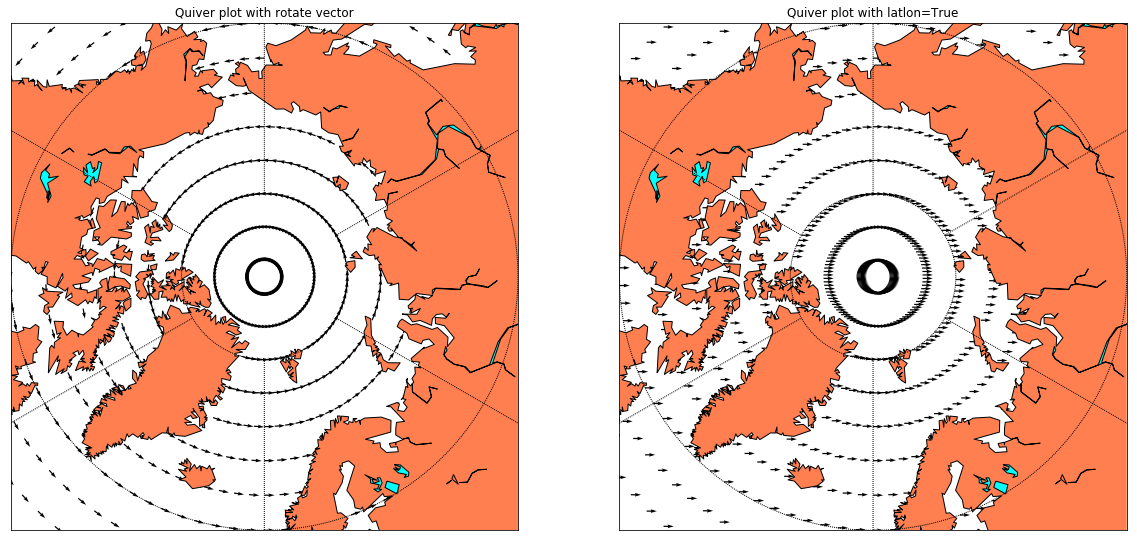

In [17]:
fig = compare_methods_polar(U_east,V_east,lon_adjust,lat,st=20, scale=50)

latlon=True cannot be used with polar projections.

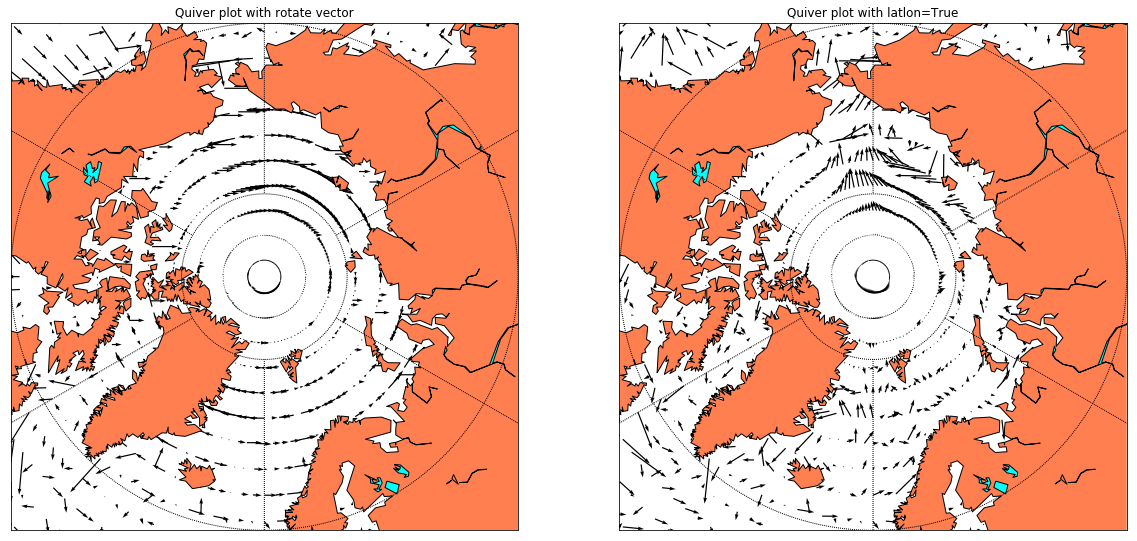

In [18]:
fig = compare_methods_polar(U_GIOPS_adjust,V_GIOPS_adjust,lon_adjust,lat,st=15,scale=5)

Am I misunderstanding how rotate_vector works and/or GIOPS velocities???